In [1]:
from chdrft.config.env import init_jupyter

init_jupyter()
from chdrft.sim.traj import tgo
from chdrft.sim.gz import helper
from chdrft.sim.rb import rb_gen
from chdrft.sim.rb import base as rb_base
from chdrft.sim.rb.base import Vec3, Transform
from chdrft.sim.rb import scenes
import seaborn as sns
import datetime
from gz import sim7, math7
from chdrft.gnc import ctrl
import chdrft.dsp.utils as dsp_utils

Runnign magic qt5
done
False


/home/benoit/.virtualenvs/env3.10/lib/python3.10/site-packages/pygmo/__init__.py:113: DeprecationWarning: invalid escape sequence '\l'
  """


Registering [gz_sim_components.Environment] = 1433709137331907826
Registering [gz_sim_components.CanonicalLink] = 1899862455720879825
Registering [gz_sim_components.ModelCanonicalLink] = 2958716330662201668
Registering [gz_sim_components.ChildLinkName] = 18008977594029503042
Registering [gz_sim_components.Joint] = 18371370647956686351
Registering [gz_sim_components.Link] = 14769025567331365649
Registering [gz_sim_components.Name] = 17448053894352336366
Registering [gz_sim_components.ParentEntity] = 50322453549405034
Registering [gz_sim_components.ParentLinkName] = 11426747106486107602
Registering [gz_sim_components.Recreate] = 6579594356939739964
Registering [gz_sim_components.World] = 5975074572899138571
Registering [gz_sim_components.WorldSdf] = 18076026013665852038
Registering [gz_sim_components.Actor] = 11808826388832216226
Registering [gz_sim_components.AnimationTime] = 17600374756001327636
Registering [gz_sim_components.AnimationName] = 11035508405656207414
Registering [gz_sim_co

In [64]:
ang = np.pi/30
target_z = Vec3([0.01, -0.01, 1]).uvec
target_z = rb_base.Transform.From(rot=rb_base.R.from_euler('yx', np.ones(2) *ang)) @ Vec3.Z()

V([0.1045285, -0.1039558, 0.9890738,])

In [113]:
class Controller:
    def __init__(self, target_z):
        max_ang  = np.pi/4
        self.pid = ctrl.PIDController(kp=3, kd=3, control_range=ctrl.Range1D(-max_ang, max_ang))
        self.target_z = target_z
        
    def proc(self, wl : rb_base.Transform) -> rb_base.Vec3:
        target_local = wl.inv @ target_z
        proj = -target_local[:2]
        action = self.pid.push(proj)
        rotx = rb_base.Transform.From(rot=rb_base.R.from_euler('yx', action * [1, -1]))
        return rotx @ Vec3.Z()
cx = Controller(target_z)

base = './traj.sdf'
sd = scenes.balance_scene()

step = 0.01
sim_time=  5

with cmisc.tempfile.NamedTemporaryFile() as tf:
    conv = helper.SDFConverter(base, world_name='scene1')
    conv.fill_with_rbtree(sd.tree)
    conv.write(tf.name)

    runner = helper.GZRunner.Build(tf.name)
    runner.set_physics(step)
    model = runner.model(helper.SDFConverter.MODEL_NAME)

    root_link = sim7.Link(model.link_by_name(runner.ecm, 'root'))
    box_link = sim7.Link(model.link_by_name(runner.ecm, 'root.RigidBodyLinkType.RIGID_SolidSpecType.BOX'))
   
    t0 = 0

    def conf_cb(*args):
        t = runner.info.sim_time.total_seconds()
        model_tsf = helper.GZDatas.tsf.query(runner, model.entity())
        dir = cx.proc(model_tsf)
        runner.set_force(box_link, model_tsf @ dir*200)
        runner.set_vel(model, Vec3.Zero())
        model_tsf.pos_v = Vec3.Zero()
        sim7.WorldPoseCmd.GetOrCreate(runner.ecm, model.entity()).set_data(model_tsf.to_gz())

        #sim7.InertialCmd.GetOrCreate(runner.ecm, link.entity()).set_data(a)

    runner.callbacks[helper.GZCallbackMode.PRE].append(conf_cb)

    from chdrft.sim.gz.helper import *
    stats = StatsGatherer(requests=[
        helper.GZDatas.tsf.make_request('model', model.entity()),
    ], iter_downsample=10)
    stats.register(runner)

    #runner.reset()
    runner.server.run(True, int(sim_time / step), False)
    dfx = pd.DataFrame.from_records(stats.records)
    runner.server.stop()
    runner.fixture.release()
    #del runner

#try_spec(spec)i

lease2
[Dbg] [SimulationRunner.cc:540] Exiting postupdate worker thread (0)
[Dbg] [SimulationRunner.cc:540] Exiting postupdate worker thread (1)
[Msg] Loading SDF world file[/tmp/tmpgrfhl70j].
[Msg] Serving entity system service on [/entity/system/add]
[Msg] Loaded level [3]
[Msg] No systems loaded from SDF, loading defaults
[Dbg] [ServerConfig.cc:1042] Loaded (3) plugins from file [/home/benoit/.gz/sim/7/server.config]
[Dbg] [Physics.cc:901] Loaded [gz::physics::dartsim::Plugin] from library [/usr/lib/gz-physics-6/engine-plugins/libgz-physics-dartsim-plugin.so]
[Dbg] [SystemManager.cc:74] Loaded system [gz::sim::systems::Physics] for entity [1]
[Msg] Create service on [/world/scene1/create]
[Msg] Remove service on [/world/scene1/remove]
[Msg] Pose service on [/world/scene1/set_pose]
[Msg] Pose service on [/world/scene1/set_pose_vector]
[Msg] Light configuration service on [/world/scene1/light_config]
[Msg] Physics service on [/world/scene1/set_physics]
[Msg] SphericalCoordinates servi

[Err] [Conversions.cc:1722] Tried to convert SDF [world] into [plugin]
release
release


<AxesSubplot: xlabel='sim_time'>

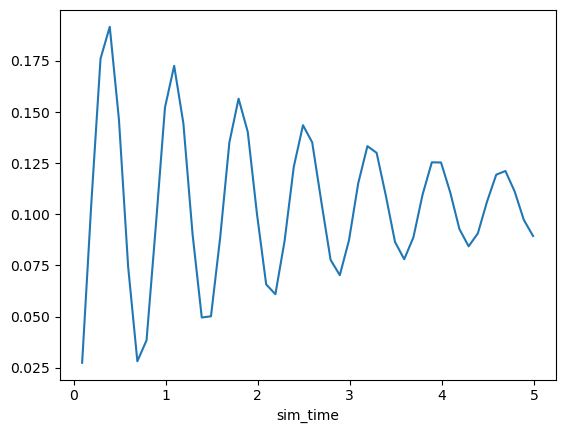

In [114]:
xp = np.stack(dfx['model.tsf'].apply(lambda x: (x @ Vec3.Z()).vdata).values)
tt = dfx.sim_time.apply(lambda x:x.total_seconds())
sns.lineplot(x=tt, y=xp[:,0])

In [115]:
123

123